In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# load dataset into Pandas DataFrame
df = pd.read_csv("log.csv")
df.columns= ['timestamp','latency','gateway']
df = df.set_index('timestamp')
df = df.sort_index(axis=1)
df.head()


,gateway,latency
timestamp,,
01/21/19 02:32 PM,10.138.25.67,0.339817
01/21/19 02:33 PM,10.138.25.67,0.024861
01/21/19 02:34 PM,10.138.25.67,0.022789
01/21/19 02:35 PM,10.138.25.67,0.022000
01/21/19 02:36 PM,10.138.25.67,0.025834


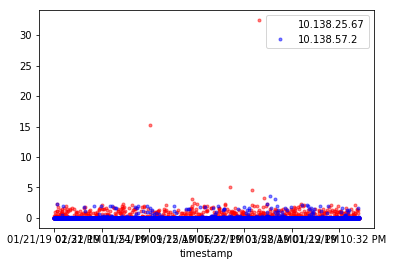

0.026701


In [2]:
fig, ax = plt.subplots()

colors = {'10.138.25.67':'red', '10.138.57.2':'blue'}

grouped = df.groupby('gateway')
for key, group in grouped:
    group.plot(ax=ax, style='.k',  y='latency', label=key, color=colors[key],alpha=0.5)

#plt.ylim(0,5)
plt.show()

print(df['latency'].quantile(0.9))



In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import os


INPUT_DIR = os.path.join( os.getcwd(), "logs")
data = pd.DataFrame()
dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR))]    
#print(dirs)
data = {}
for client in dirs:
    files = [f for f in os.listdir(INPUT_DIR+"/"+client) if os.path.isdir(os.path.join(INPUT_DIR,client))]
    client_data = pd.DataFrame()
    for file in files:
        temp =  pd.read_csv(os.path.join(INPUT_DIR, client,file), sep=',')
        temp.columns= ['timestamp','ttfb','latency','gateway','status']
        client_data = pd.concat([client_data,temp])
    client_data = client_data.set_index(pd.DatetimeIndex(client_data['timestamp']))
    client_data.index = client_data.index.map(lambda x: x.replace(second=0, microsecond=0))
    client_data['timestamp'] = pd.DatetimeIndex(client_data['timestamp']).map(lambda x: x.replace(second=0, microsecond=0))

    data[client] = client_data


In [108]:
def get_min_date():
    min_date = None
    for d in data:
        c = data.get(d)
        if min_date is None or min_date > c.index.min():
            min_date = c.index.min()
    return min_date#.strftime("%m/%d/%Y, %H:%M:%S")

def get_max_date():
    max_date = None
    for d in data:
        c = data.get(d)
        if max_date is None or max_date > c.index.max():
            max_date = c.index.max()
    return max_date

def get_99th_percentile():
    df = pd.DataFrame()
    for d in data:
        df = pd.concat([df,data.get(d)])
        
    #print(df.describe())
    #print(df['latency'].max())
    #print(df['latency'].min())
    #print(df['latency'].mean())
    p90 = df['latency'].quantile(0.99)    
    return df.query('latency<'+str(p90))['latency'].mean()

def send_info(ts):
    min_date = None
    max_date = None
    
    gateway_table = pd.DataFrame()
    for d in data:
        c = data.get(d)[ts]
        c['sender'] = d
        if len(c)>2:
            gateway_table = pd.concat([gateway_table , c.sample(n=2)])
        elif len(c)>0:
            gateway_table = pd.concat([gateway_table , c])
    #print(gateway_table)
    return gateway_table
    
import numpy as np
import math
def cosine_similarity(a,b):
    return sum([i*j for i,j in zip(a, b)])/(math.sqrt(sum([i*i for i in a]))* math.sqrt(sum([i*i for i in b])))
    
        
        

In [135]:
def calculate_trust_score(trust_score, gateway_table):
    gateways = gateway_table.query('sender == "c0_1"')
    rest = gateway_table.query('sender != "c0_1"')
    rest = rest[rest.gateway.isin(gateways['gateway'].values)]
    for index, row in rest.iterrows():
        gw = gateways.query('gateway == "'+row['gateway']+'"')
        value = abs(gw['latency'].values[0] - row['latency'])

        if row['sender'] in trust_score:
            trust_score[row['sender']] = 2/3*value + 1/3*trust_score[row['sender']]
        else:
            trust_score[row['sender']] = value
    
    return trust_score

def calculate_trust_score_transitive(trust_score, gateway_table, node):
    trusted = []
    trusted.extend(list(trust_score.keys()))
    trusted.append(node)
        
    gateways= gateway_table[gateway_table.sender.isin(trusted)]
    
    rest = gateway_table[~gateway_table.sender.isin(trusted)]
    rest = rest[rest.gateway.isin(gateways['gateway'].values)]
    #print(rest[['gateway','sender']])
    cnt = 0
    for index, row in rest.iterrows():
        gw = gateways.query('gateway == "'+row['gateway']+'"')
        value = abs(gw['latency'].values[0] - row['latency'])

        if row['sender'] in trust_score:
            trust_score[row['sender']] = 2/3*value + 1/3*trust_score[row['sender']]
            cnt+=1
        else:
            trust_score[row['sender']] = value
            cnt+=1
    
    #print(cnt)
    
    return trust_score
    

In [94]:

# Gateway table with all collaborators and MA
def build_gateway_table(gateway_table, new_df, ts):
    #print(new_df['gateway'].unique())
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    
    for name, group in df_period:
        cnt = 1
        size = len(group)
        
        mv_value = 0
        if name in gateway_table:
            cnt +=1
            size +=1
            mv_value +=gateway_table[name]
        
        summa = sum(range(1,size+1))
        for index, row in group.iterrows():
            mv_value += cnt*row['latency']
            cnt +=1
        
        mv_value = mv_value/summa
        #print(name,mv_value)
        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)
    
#Gateway table with latest measurement without ma
def build_gateway_table1(gateway_table, new_df, ts):
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    
    for name, group in df_period:
        size = len(group)
        mv_value = group['latency'].values[size-1]
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
            
            #print(name, mv_value, df_actual['latency'].values[0])
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

#Gateway table with MA and TOP K collaborators (absolute error)
def build_gateway_table2(gateway_table, new_df, trust_score, ts):
    trusted_col = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:4])
    new_df = new_df[new_df.sender.isin(trusted_col.keys())]
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    for name, group in df_period:
        cnt = 1
        size = len(group)
        
        mv_value = 0
        if name in gateway_table:
            cnt +=1
            size +=1
            mv_value +=gateway_table[name]
        
        summa = sum(range(1,size+1))
        for index, row in group.iterrows():
            mv_value += cnt*row['latency']
            cnt +=1
        
        mv_value = mv_value/summa
        #print(name,mv_value)
        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

In [95]:
# Gateway table with all collaborators without MA
def build_gateway_table_no_ma(gateway_table, new_df,trust_score, ts):
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = []     
    for name, group in df_period:        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            for index, row in group.iterrows():                
                actual.append(df_actual['latency'].values[0])
                gw_t.append(row['latency'])
                
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

# Gateway table with TOP K collaborators without MA
def build_gateway_table_no_ma_topk(gateway_table, new_df,trust_score, ts, k):
    trusted_col = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:k])
    new_df = new_df[new_df.sender.isin(trusted_col.keys())]
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = []     
    for name, group in df_period:        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            for index, row in group.iterrows():                
                actual.append(df_actual['latency'].values[0])
                gw_t.append(row['latency'])
                
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

def build_gateway_table_ma_topk_error(gateway_table, new_df, trust_score, faulty_nodes):
    trusted_col = dict(sorted(trust_score.items(),key=lambda kv: kv[1])[:4])
    
    new_df = new_df[new_df.sender.isin(trusted_col.keys())]
    df_period = new_df.groupby(new_df['gateway'])
    actual = []
    gw_t = [] 
    for name, group in df_period:
        cnt = 1
        size = len(group)
        
        mv_value = 0
        if name in gateway_table:
            cnt +=1
            size +=1
            mv_value +=gateway_table[name]
        
        summa = sum(range(1,size+1))
        for index, row in group.iterrows():
            mv_value += cnt*row['latency']
            cnt +=1
        
        mv_value = mv_value/summa
        #print(name,mv_value)
        
        df_actual = data['c0_1'].query('timestamp == "'+ts+'" and gateway == "'+name+'"')
        if len(df_actual) >0:
            actual.append(df_actual['latency'].values[0])
            gw_t.append(mv_value)
    if len(actual) == 0 or len(gw_t) == 0:
        return None
    return cosine_similarity(actual, gw_t)

In [171]:
#print(data['c2_2'][['gateway','latency']]) 
data['c2_2']['latency'] = data['c2_2']['latency']*10 

timestamp
2019-01-21 14:35:00    2.57984
2019-01-21 14:36:00    1.78664
2019-01-21 14:37:00    1.82187
2019-01-21 14:38:00    1.79872
2019-01-21 14:39:00    1.86970
2019-01-21 14:40:00    1.76158
2019-01-21 14:41:00    1.84896
2019-01-21 14:42:00    1.83721
2019-01-21 14:43:00    1.79328
2019-01-21 14:44:00    1.85215
2019-01-21 14:45:00    1.79698
2019-01-21 14:46:00    1.79601
2019-01-21 14:47:00    1.80826
2019-01-21 14:48:00    1.81106
2019-01-21 14:49:00    1.80974
2019-01-21 14:50:00    1.85573
2019-01-21 14:51:00    1.80705
2019-01-21 14:52:00    1.82267
2019-01-21 14:53:00    1.85020
2019-01-21 14:54:00    1.79740
2019-01-21 14:55:00    1.78580
2019-01-21 14:56:00    1.90883
2019-01-21 14:57:00    1.85969
2019-01-21 14:58:00    1.90768
2019-01-21 14:59:00    1.94400
2019-01-21 15:00:00    1.87567
2019-01-21 15:01:00    1.89033
2019-01-21 15:02:00    1.83528
2019-01-21 15:03:00    1.86935
2019-01-21 15:04:00    1.80343
                        ...   
2019-02-13 11:22:00    0.2054

In [172]:
print(data['c2_2']['latency'])

timestamp
2019-01-21 14:35:00    2.57984
2019-01-21 14:36:00    1.78664
2019-01-21 14:37:00    1.82187
2019-01-21 14:38:00    1.79872
2019-01-21 14:39:00    1.86970
2019-01-21 14:40:00    1.76158
2019-01-21 14:41:00    1.84896
2019-01-21 14:42:00    1.83721
2019-01-21 14:43:00    1.79328
2019-01-21 14:44:00    1.85215
2019-01-21 14:45:00    1.79698
2019-01-21 14:46:00    1.79601
2019-01-21 14:47:00    1.80826
2019-01-21 14:48:00    1.81106
2019-01-21 14:49:00    1.80974
2019-01-21 14:50:00    1.85573
2019-01-21 14:51:00    1.80705
2019-01-21 14:52:00    1.82267
2019-01-21 14:53:00    1.85020
2019-01-21 14:54:00    1.79740
2019-01-21 14:55:00    1.78580
2019-01-21 14:56:00    1.90883
2019-01-21 14:57:00    1.85969
2019-01-21 14:58:00    1.90768
2019-01-21 14:59:00    1.94400
2019-01-21 15:00:00    1.87567
2019-01-21 15:01:00    1.89033
2019-01-21 15:02:00    1.83528
2019-01-21 15:03:00    1.86935
2019-01-21 15:04:00    1.80343
                        ...   
2019-02-13 11:22:00    0.2054

In [ ]:
import datetime

min_date = get_min_date() 
max_date = get_max_date() 

start = min_date
end_date = start+datetime.timedelta(minutes = 1440)

#end_date = start+datetime.timedelta(minutes = 100)
history_gateway_table = pd.DataFrame()
gateway_table = {}
trust_score = {}
trust_score_transitive = {}
clients = {}
gw_table_similarity_ma = pd.DataFrame()
gw_table_similarity = pd.DataFrame()
gw_table_similarity_ma_top = pd.DataFrame()

gw_table_similarity_no_ma = pd.DataFrame()
gw_table_similarity_no_ma_top4 = pd.DataFrame()
gw_table_similarity_no_ma_top5 = pd.DataFrame()
gw_table_similarity_no_ma_top6 = pd.DataFrame()
gw_table_similarity_no_ma_top7 = pd.DataFrame()
#f = open('similarity_abs.csv','w')
while(start < end_date):
    rt = send_info(start.strftime("%m/%d/%Y, %H:%M:%S"))
    gws = rt.query('sender=="c0_1"')['gateway'].values
    
    for index, row in rt.iterrows():
        if row["gateway"] in gws:
            if row['sender'] == "c0_1":
                continue
            if row["sender"] not in clients:
                clients[row["sender"]] = 1
            else:
                clients[row["sender"]] += 1
    
    #print(rt[['gateway','latency','sender']])
    
    
    history_gateway_table = pd.concat([history_gateway_table, rt])
    no_gws = len(history_gateway_table['gateway'].unique())
    #no_senders = len(history_gat)
    trust_score = calculate_trust_score(trust_score, rt)
    trust_score_transitive = calculate_trust_score_transitive(trust_score_transitive, rt, 'c0_1')
    
    gw_table_similarity_no_ma = gw_table_similarity_no_ma.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"),
                                                                 'similarity':build_gateway_table_no_ma(gateway_table, rt, trust_score, start.strftime("%m/%d/%Y, %H:%M:%S"))}, 
                                                                 ignore_index=True)
    gw_table_similarity_no_ma_top4 = gw_table_similarity_no_ma_top4.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"),
                                                                 'similarity':build_gateway_table_no_ma_topk(gateway_table, rt, trust_score, start.strftime("%m/%d/%Y, %H:%M:%S"), 4)}, 
                                                                 ignore_index=True)
    
    #gw_table_similarity_ma = gw_table_similarity_ma.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"), 
    #                                                       'similarity':build_gateway_table(gateway_table, rt, start.strftime("%m/%d/%Y, %H:%M:%S"))}, 
    #                                                      ignore_index=True) 
    #gw_table_similarity = gw_table_similarity.append({'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"), 'similarity':build_gateway_table1(gateway_table, rt, start.strftime("%m/%d/%Y, %H:%M:%S"))}, ignore_index=True)
    
    gw_table_similarity_ma_top = gw_table_similarity_ma_top.append({
        'timestamp':start.strftime("%m/%d/%Y, %H:%M:%S"), 
        'similarity':build_gateway_table2(gateway_table, rt, trust_score, start.strftime("%m/%d/%Y, %H:%M:%S"))
    },  ignore_index=True)
    start = start+datetime.timedelta(minutes=2)

#gw_table_similarity_ma.to_csv("similarity_abs_ma.csv")
gw_table_similarity_ma_top.to_csv("similarity_abs_ma_top_error10.csv")
#gw_table_similarity.to_csv("similarity.csv")
#print(gw_table_similarity)
    


/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [165]:
print(get_99th_percentile())

0.15623515279615907


In [9]:
def getECDF(df):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df.similarity.value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()    
    return ecdf

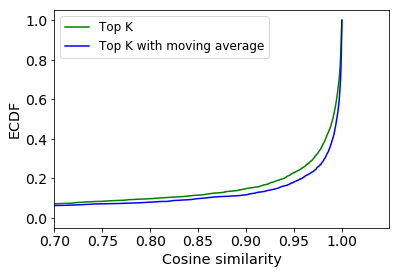

In [161]:
#gw_table_similarity_ma.set_index(pd.DatetimeIndex(gw_table_similarity_ma['timestamp']))
#gw_table_similarity.set_index(pd.DatetimeIndex(gw_table_similarity['timestamp']))
#gw_table_similarity_ma_top.set_index(pd.DatetimeIndex(gw_table_similarity_ma_top['timestamp']))

gw_table_similarity_no_ma.set_index(pd.DatetimeIndex(gw_table_similarity_no_ma['timestamp']))
gw_table_similarity_no_ma_top4.set_index(pd.DatetimeIndex(gw_table_similarity_no_ma_top4['timestamp']))

getECDF(gw_table_similarity_no_ma_top4).plot(color='green')
#getECDF(gw_table_similarity_no_ma_top5).plot(color='blue')
#getECDF(gw_table_similarity_no_ma_top6).plot(color='orange')
#getECDF(gw_table_similarity_no_ma_top7).plot(color='cyan')

#getECDF(gw_table_similarity).plot(color='red')
#getECDF(gw_table_similarity_no_ma).plot(color='red')

getECDF(gw_table_similarity_ma_top).plot(color='blue')

plt.legend(['Top K', 'Top K with moving average'], fontsize = 'large')
plt.ylabel('ECDF', fontsize = 'x-large')
plt.xlabel('Cosine similarity', fontsize = 'x-large')

plt.xlim(0.7)

plt.tick_params(axis='both', which='major', labelsize=14)
#plot.tick_params(axis='both', which='minor', labelsize=8)


plt.show()